In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import csv as csv
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


In [8]:
#Importing all tge data
df = pd.read_excel ("D:/Users/Ivič/Documents/faks/Capstone/shelter-animal-outcomes/train.xlsx")
tt = pd.read_excel ("D:/Users/Ivič/Documents/faks/Capstone/shelter-animal-outcomes/test.xlsx")
df = df.set_index('AnimalID')

In [9]:
#Let us first see the first few values of the dataset
df.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [10]:
#Let's see if there are any values missing in our dataset
df.isna().sum()

Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [11]:
#Check the outcome possibilities
df["OutcomeType"].unique()

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'],
      dtype=object)

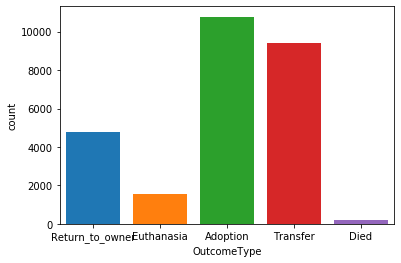

In [12]:
# See the distribution of outcome
sns.countplot(x="OutcomeType",data=df, saturation=1.69)


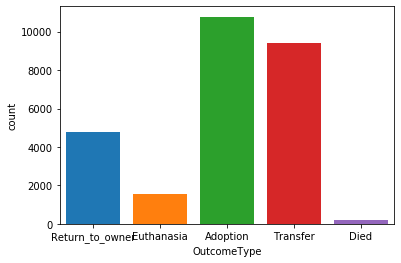

In [13]:
# See the distribution of outcome
sns.countplot(x="OutcomeType",data=df, saturation = 1.69)

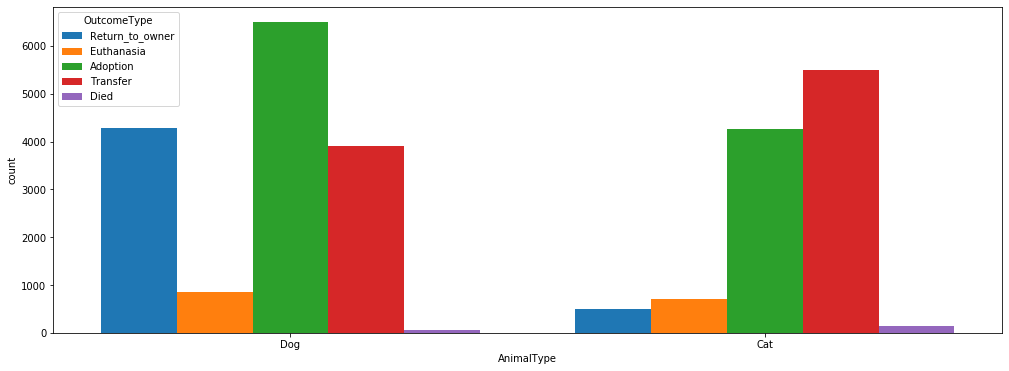

In [14]:
# See the outcome based on animal type
plt.figure(figsize=(17,6))
sns.countplot(x="AnimalType",hue="OutcomeType",data=df, saturation = 1.69)

In [15]:
#Let's see what is contained in the column "SexuponOutcome"
df["SexuponOutcome"].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

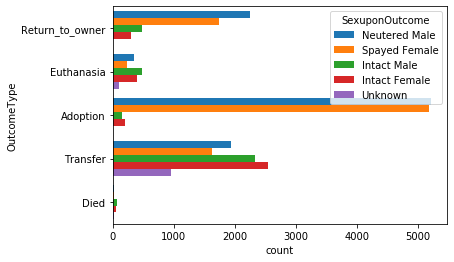

In [16]:
# Since there are some Nan, but also Unknown, we will transform all the Nan to Unknown
df["SexuponOutcome"]=df["SexuponOutcome"].fillna("Unknown")

# Plot outcome based on sex
sns.countplot(y="OutcomeType",data=df,hue="SexuponOutcome", saturation=1.69)


## Seasonality
Let us now make a time series, and see whether there is any seasonality in the outcome types of the animals

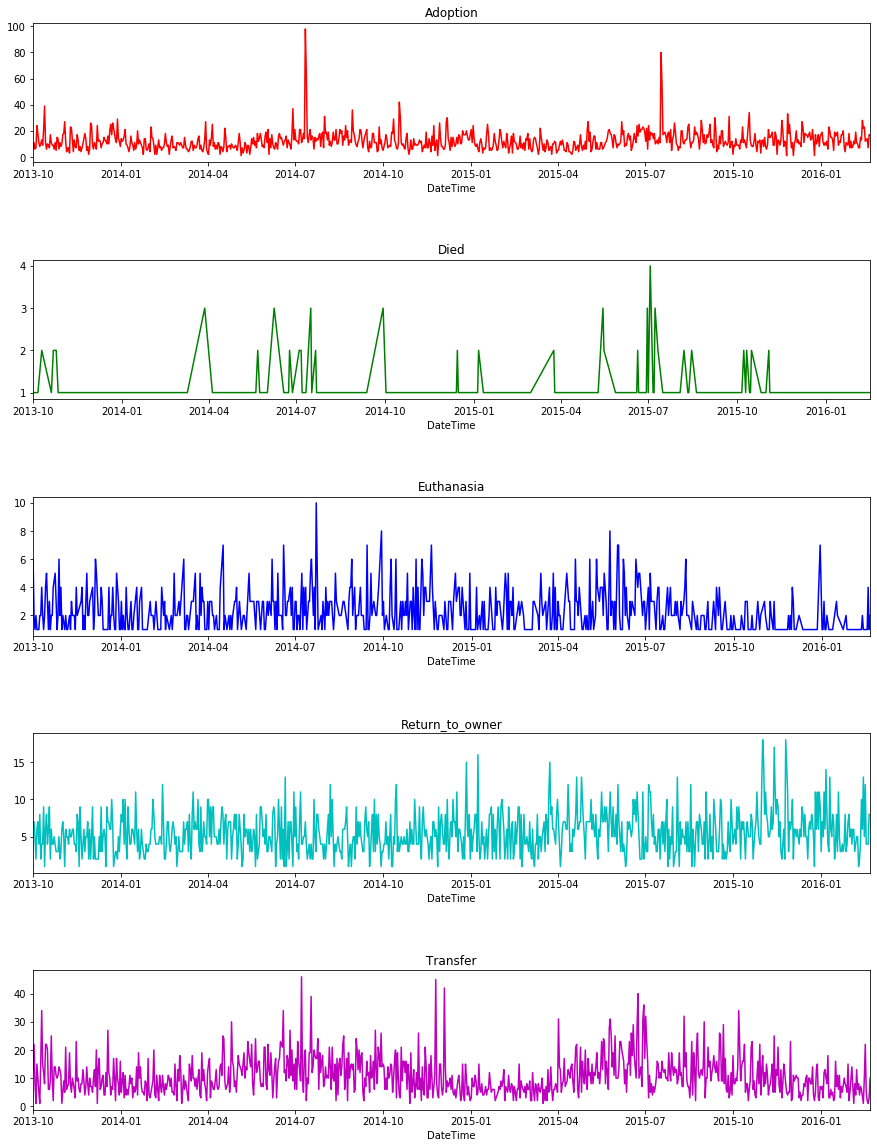

In [17]:
# Time series for each outcome
df["DateTime"] = pd.to_datetime(df["DateTime"]).dt.date
monthGroup=df["DateTime"].groupby(df["OutcomeType"])
plt.subplots(5, 1, figsize=(15, 20), sharex=True)
plt.subplots_adjust( hspace=0.7)
colors = list('rgbcmyk')
for i, (_, g) in enumerate(monthGroup):
    plt.subplot(5,1,i+1)
    plt.title(_)
    g.groupby(df["DateTime"]).count().plot(kind="line", color=colors[i])

From the data presented as above, there is no real posibillity to see what is happening and when
To rectify this, we will make some monthtly time series visualisations

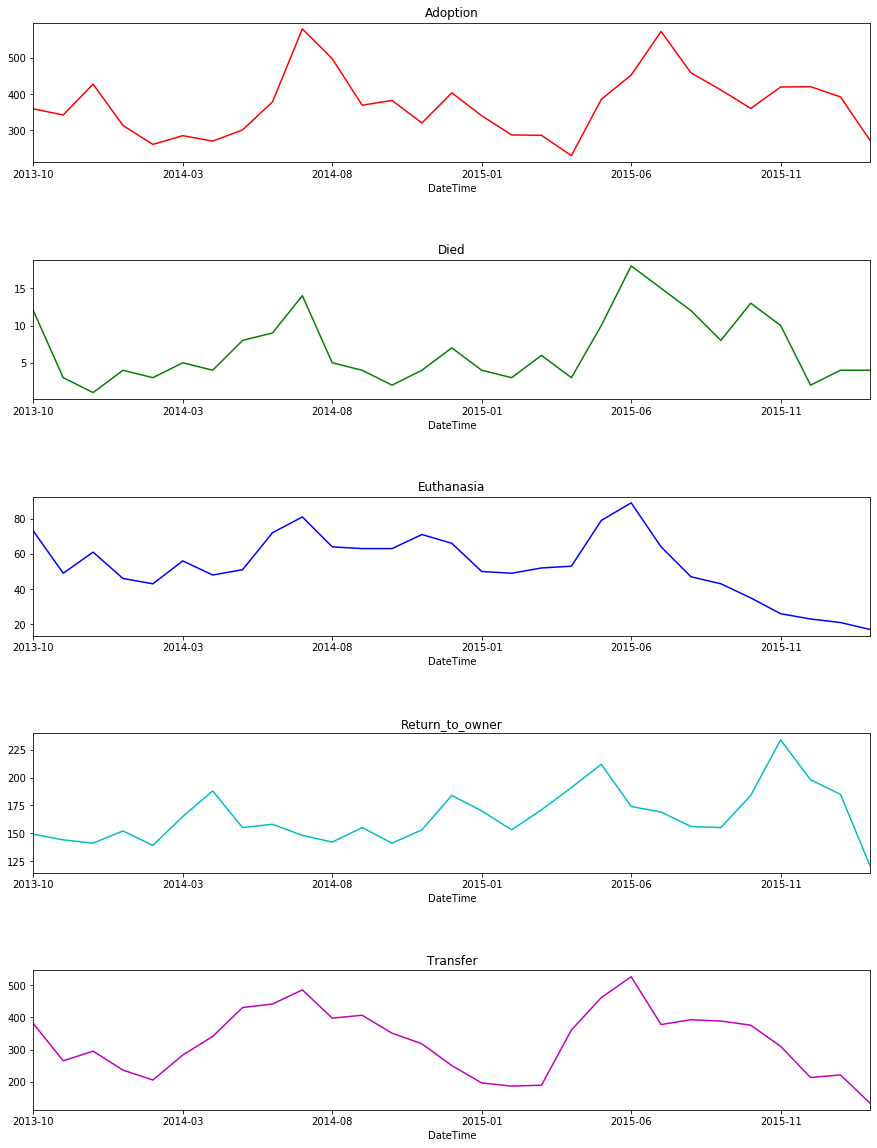

In [18]:
#Monthly time series
df_ym=df.DateTime.map(lambda x: x.strftime('%Y-%m'))
df_ym_outcomeGroup = df_ym.groupby(df["OutcomeType"])

plt.subplots(5, 1, figsize=(15, 20), sharex=True)
plt.subplots_adjust( hspace=0.7)
colors = list('rgbcmyk')
for i, (_, g) in enumerate(df_ym_outcomeGroup):
    plt.subplot(5,1,i+1)
    plt.title(_)
    g.groupby(df_ym).count().plot(kind="line", color=colors[i])

With the data visualised as above, we can conclude that both transfers and adoptions seem to be higher during the summer and then slow down during the winter months

Another important adoption parameter is age, but in the data, we have it written in different units; years, months, weeks and days. We will need to turn those words in numbers in order to make a proper visualization.
To start off, let's take a look at how many animals of each age are there in the shelter.

In [19]:
def calc_age_in_years(x):
    x = str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year') > -1: return age 
    if x.find('month')> -1: return age / 12.
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0

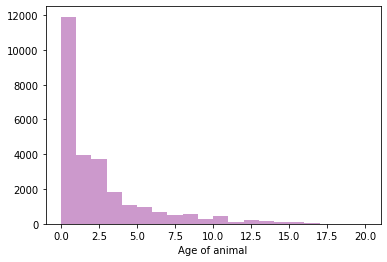

In [20]:
df['AgeInYears'] = df.AgeuponOutcome.apply(calc_age_in_years)
sns.distplot(df.AgeInYears, bins = 20, kde=False, color='purple', axlabel = 'Age of animal')



Most of the animals in the shelter less than a year old. Let's see if we can see the effect of the age of the animal on their outcome from the graph.


Most of the animals in the shelter are 0-1 years old. Let's see if age has some effect on outcome.
To be able to visualize it nicely, we will make categories out of the years of animals

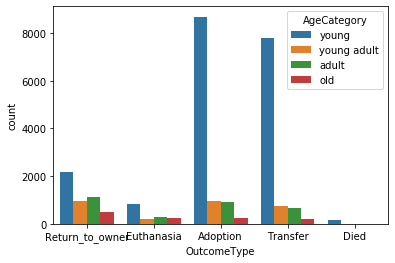

In [21]:
def calc_age_category(x):
    if x < 3: return 'young'
    if x < 5: return 'young adult'
    if x < 10: return 'adult'
    return 'old'
df['AgeCategory'] = df.AgeInYears.apply(calc_age_category)
sns.countplot(data=df, x='OutcomeType',hue='AgeCategory')

As might be expected, younger animals have a higher chance of being adopted or transferred. Adult and older animals have almost equal probabilites of being returned to owner, adopted or transfered.

In [22]:
# Prepare for training data
ytrain = df["OutcomeType"]
Xtrain = df.drop(["OutcomeType","OutcomeSubtype","AgeuponOutcome","Name", "AgeCategory"], axis=1)
Xtrain.head()

,DateTime,AnimalType,SexuponOutcome,Breed,Color,AgeInYears
AnimalID,,,,,,
A671945,2014-02-12,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White,1.000000
A656520,2013-10-13,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby,1.000000
A686464,2015-01-31,Dog,Neutered Male,Pit Bull Mix,Blue/White,2.000000
A683430,2014-07-11,Cat,Intact Male,Domestic Shorthair Mix,Blue Cream,0.057692
A667013,2013-11-15,Dog,Neutered Male,Lhasa Apso/Miniature Poodle,Tan,2.000000


In [23]:
# Encode categorical data
from sklearn import preprocessing
le_anima = preprocessing.LabelEncoder()
Xtrain.AnimalType = le_anima.fit_transform(Xtrain.AnimalType)
le_sex = preprocessing.LabelEncoder()
Xtrain.SexuponOutcome = le_sex.fit_transform(Xtrain.SexuponOutcome)
le_breed = preprocessing.LabelEncoder()
Xtrain.Breed = le_breed.fit_transform(Xtrain.Breed)
le_color = preprocessing.LabelEncoder()
Xtrain.Color = le_color.fit_transform(Xtrain.Color)
le_out = preprocessing.LabelEncoder()
ytrain = le_out.fit_transform(ytrain)

In [24]:
#Let's see
Xtrain.head()

,DateTime,AnimalType,SexuponOutcome,Breed,Color,AgeInYears
AnimalID,,,,,,
A671945,2014-02-12,1,2,1221,130,1.000000
A656520,2013-10-13,0,3,640,167,1.000000
A686464,2015-01-31,1,2,1066,86,2.000000
A683430,2014-07-11,0,1,640,42,0.057692
A667013,2013-11-15,1,2,914,274,2.000000


In [25]:
## Explode date time
xdt=pd.to_datetime(Xtrain.DateTime)
Xtrain["dow"] = xdt.dt.dayofweek
Xtrain["month"] = xdt.dt.month
Xtrain["year"] = xdt.dt.year

In [26]:
Xtrain=Xtrain.drop(["DateTime"],axis=1)
Xtrain.head()

,AnimalType,SexuponOutcome,Breed,Color,AgeInYears,dow,month,year
AnimalID,,,,,,,,
A671945,1,2,1221,130,1.000000,2,2,2014
A656520,0,3,640,167,1.000000,6,10,2013
A686464,1,2,1066,86,2.000000,5,1,2015
A683430,0,1,640,42,0.057692,4,7,2014
A667013,1,2,914,274,2.000000,4,11,2013


In [27]:
#Replacing all Nan in the training dataset with -1
#we dn0t use 0 because it's already used in the dataset
Xtrain=Xtrain.fillna(-1)


In [28]:
from sklearn.ensemble import RandomForestClassifier
# Do random forest
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
# Let's see the train accuracy
tra_score=rf.score(Xtrain, ytrain)
print("Training accuracy ",tra_score)

Training accuracy  0.9923304276254256


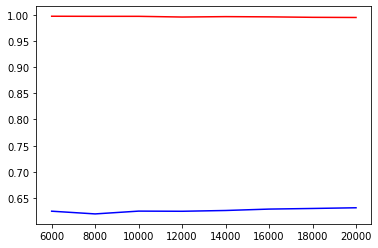

In [30]:
from sklearn.ensemble import RandomForestClassifier
m=[6000,8000,10000,12000,14000,16000,18000,20000]
train_err=[]
val_err=[]
perm=np.random.permutation(len(Xtrain))
Xtr=Xtrain.iloc[perm[0:20000]]
ytr=ytrain[perm[0:20000]]
Xval=Xtrain.iloc[perm[20001:]]
yval=ytrain[perm[20001:]]
for i in range(8):
    trainSize = m[i]
    perm=np.random.permutation(len(Xtr))
    XtrNow = Xtr.iloc[perm[0:trainSize]]
    ytrNow = ytr[perm[0:trainSize]]
    # Do random forest
    rf = RandomForestClassifier(n_estimators=1000)
    rf.fit(XtrNow, ytrNow)
    # Let's see the train accuracy
    rScore=rf.score(XtrNow, ytrNow)
    vScore=rf.score(Xval, yval)
    train_err.append(rScore)
    val_err.append(vScore)
plt.plot(m, train_err, 'r', m, val_err, 'b')

In [43]:
IDtest=tt["ID"]
Xtest=tt.drop(["ID","Name", "AgeuponOutcome",], axis=1)

Xtest.AnimalType = le_anima.fit_transform(Xtest.AnimalType)
Xtest.SexuponOutcome = le_sex.fit_transform(Xtest.SexuponOutcome)
Xtest.Breed = le_breed.fit_transform(Xtest.Breed)
Xtest.Color = le_color.fit_transform(Xtest.Color)
Xtest.head()

,DateTime,AnimalType,SexuponOutcome,Breed,Color
0,2015-10-12 12:15:00,1,0,542,185
1,2014-07-26 17:59:00,1,3,460,28
2,2016-01-13 12:20:00,0,2,407,79
3,2013-12-28 18:12:00,1,1,345,229
4,2015-09-24 17:59:00,1,2,633,238


In [44]:
xdt=pd.to_datetime(Xtest.DateTime)
Xtest["dow"] = xdt.dt.dayofweek
Xtest["month"] = xdt.dt.month
Xtest["year"] = xdt.dt.year
Xtest=Xtest.drop(["DateTime"],axis=1)
Xtest.head()

,AnimalType,SexuponOutcome,Breed,Color,dow,month,year
0,1,0,542,185,0,10,2015
1,1,3,460,28,5,7,2014
2,0,2,407,79,2,1,2016
3,1,1,345,229,5,12,2013
4,1,2,633,238,3,9,2015


## References:

https://www.kaggle.com/uchayder/take-a-look-at-the-data

https://www.kaggle.com/albadr/shelter-animal-exploration